In [1]:
# Load the data
import os
import pandas as pd
import numpy as np


BASE_DIR = "../input/microsoft-rice-disease-classification-challenge"

train = pd.read_csv(os.path.join(BASE_DIR, 'Train.csv'))
test = pd.read_csv(os.path.join(BASE_DIR, 'Test.csv'))

In [2]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(train['Label']))}
print(class_mapping)

{'blast': 0, 'brown': 1, 'healthy': 2}


In [3]:
# 클래스 레이블을 문자열에서 정수로 바꿉니다

train['Label'] = train['Label'].map(class_mapping)
train

,Image_id,Label
0,id_004wknd7qd.jpg,0
1,id_004wknd7qd_rgn.jpg,0
2,id_005sitfgr2.jpg,1
3,id_005sitfgr2_rgn.jpg,1
4,id_00stp9t6m6.jpg,0
...,...,...
5335,id_zz6gzk7p97_rgn.jpg,1
5336,id_zz8ca2p67e.jpg,0
5337,id_zz8ca2p67e_rgn.jpg,0
5338,id_zzt8y9q0x0.jpg,1


In [4]:
train['Label'].value_counts()

0    2988
1    1532
2     820
Name: Label, dtype: int64

In [5]:
train_target = train.Label

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [7]:
from tqdm import tqdm # tqdm : 작업진행률 표시
from tensorflow.keras.preprocessing import image

img_height = 100
img_width = 100

train_scaled = []

for i in tqdm(range(train.shape[0])):
    path = os.path.join(BASE_DIR, 'Images/') + train['Image_id'][i]
    img = image.load_img(path, target_size=(img_height, img_width, 3)) # 3: RGB이므로 3채널
    img = image.img_to_array(img)
    img = img/255.0
    train_scaled.append(img)

train_scaled = np.array(train_scaled) # X와 np.array(X) 차이 ?
# 저장해두는 법

100%|██████████| 5340/5340 [02:28<00:00, 35.85it/s]


# Modeling

In [8]:
train_scaled[0].shape

(100, 100, 3)

In [9]:
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=train_scaled[0].shape ))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(3, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               2

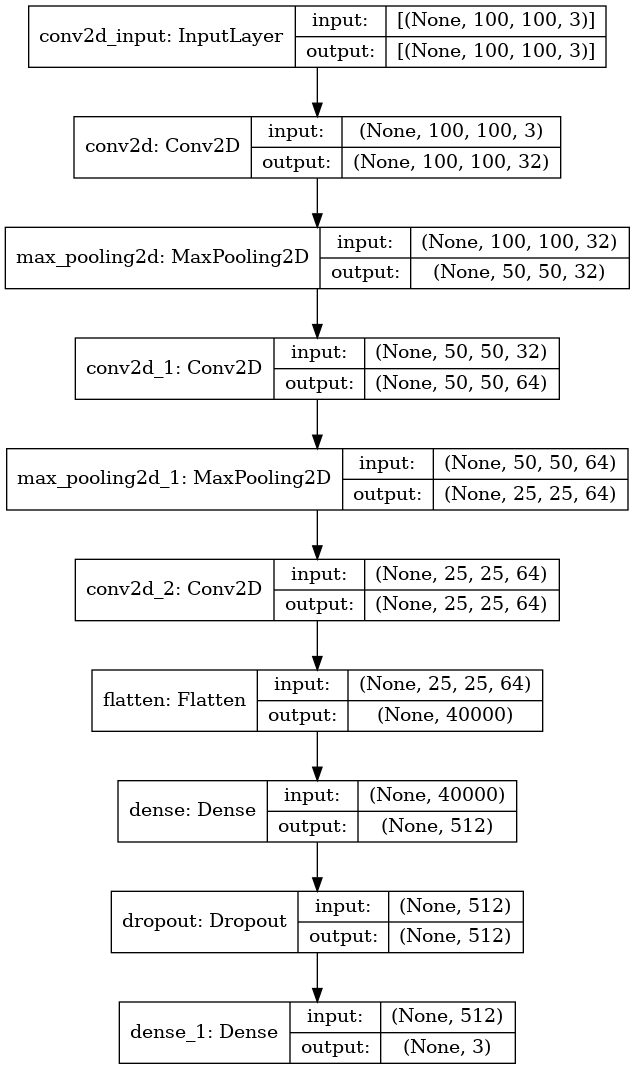

In [11]:
keras.utils.plot_model(model, show_shapes=True)

# Compiling and Training

In [12]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=50, batch_size=1000, validation_split=0.2, callbacks=[checkpoint_cb])
# , early_stopping_cb

Epoch 1/50
5/5 [==============================] - 10s 381ms/step - loss: 6.0213 - accuracy: 0.4143 - val_loss: 1.1940 - val_accuracy: 0.2959
Epoch 2/50
5/5 [==============================] - 1s 189ms/step - loss: 1.0862 - accuracy: 0.4188 - val_loss: 1.0011 - val_accuracy: 0.5468
Epoch 3/50
5/5 [==============================] - 1s 192ms/step - loss: 0.9929 - accuracy: 0.5611 - val_loss: 1.0102 - val_accuracy: 0.5468
Epoch 4/50
5/5 [==============================] - 1s 192ms/step - loss: 0.9751 - accuracy: 0.5620 - val_loss: 0.9704 - val_accuracy: 0.5468
Epoch 5/50
5/5 [==============================] - 1s 215ms/step - loss: 0.9601 - accuracy: 0.5632 - val_loss: 0.9632 - val_accuracy: 0.5468
Epoch 6/50
5/5 [==============================] - 1s 190ms/step - loss: 0.9515 - accuracy: 0.5630 - val_loss: 0.9601 - val_accuracy: 0.5468
Epoch 7/50
5/5 [==============================] - 1s 191ms/step - loss: 0.9389 - accuracy: 0.5648 - val_loss: 0.9514 - val_accuracy: 0.5590
Epoch 8/50
5/5 [===

In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

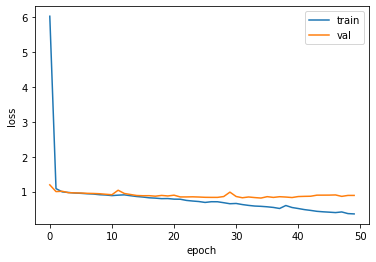

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'val'])
plt.show()

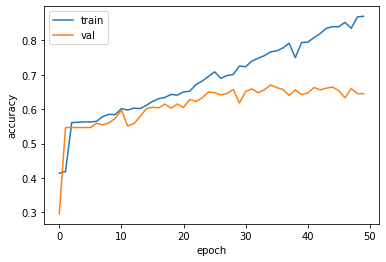

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.legend(['train', 'val'])
plt.show()

# Submit

In [16]:
sample_submission = pd.read_csv(os.path.join(BASE_DIR, 'SampleSubmission.csv'))

In [17]:
img_height = 100
img_width = 100

test_scaled = []

for i in tqdm(range(sample_submission.shape[0])):
  path = os.path.join(BASE_DIR, 'Images/') + sample_submission['Image_id'][i]
  img = image.load_img(path, target_size=(img_height, img_width, 3))
  img = image.img_to_array(img)
  img = img/255.0
  test_scaled.append(img)

test_scaled = np.array(test_scaled)

100%|██████████| 1145/1145 [00:10<00:00, 108.04it/s]


In [18]:
y_prob = model.predict(test_scaled)
print(y_prob)

[[9.3514180e-01 6.4230375e-02 6.2781904e-04]
 [5.0497937e-01 4.5990953e-01 3.5111096e-02]
 [2.4516959e-02 2.3832583e-01 7.3715723e-01]
 ...
 [3.1542718e-02 9.3902278e-01 2.9434515e-02]
 [6.3972729e-01 2.9692438e-01 6.3348345e-02]
 [9.6387613e-01 1.8183883e-02 1.7940082e-02]]


In [19]:
sample_submission.loc[:, ["blast", "brown", "healthy"]] = y_prob
sample_submission.to_csv("submission.csv", index=False)
sample_submission.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.935142,0.064230,0.000628
1,id_01hu05mtch.jpg,0.504979,0.459910,0.035111
2,id_030ln10ewn.jpg,0.024517,0.238326,0.737157
3,id_03z57m8xht.jpg,0.872496,0.025286,0.102218
4,id_04ngep1w4b.jpg,0.912940,0.078191,0.008869


**SCORE: 0.7192128478935046**